In [1]:
library(brms)
theme_set(theme_default())

Loading required package: Rcpp
Loading required package: ggplot2
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.


# Load data

In [2]:
# load RData into environment called ex
# ex contains data frames: disc_df_r, disc_df_brms, test_df
load("~/Desktop/hmax/python/compare_images/prepped_data.RData", ex <- new.env())

In [4]:
# Load test data from environment
disc_df_brms <- ex$disc_df_brms
head(disc_df_brms)

Answer,Choice,RT,Block,Trlnum,ED,CD,sub,task,item_id
1,0,1.762020,0,0,15.32376,1.1409781,1,disc,16
0,1,1.705525,0,2,15.74584,0.3656934,1,disc,8
1,0,1.595861,0,3,15.23893,0.7494049,1,disc,39
1,0,1.622645,0,4,14.99608,0.8615870,1,disc,33
1,0,1.871957,0,5,15.68364,0.4424585,1,disc,54
0,3,2.303956,0,6,15.51642,0.4315332,1,disc,10


In [5]:
str(disc_df_brms)

'data.frame':	5953 obs. of  10 variables:
 $ Answer : num  1 0 1 1 1 0 1 1 1 1 ...
 $ Choice : int  0 1 0 0 0 3 0 0 0 0 ...
 $ RT     : num  1.76 1.71 1.6 1.62 1.87 ...
 $ Block  : Ord.factor w/ 3 levels "0"<"1"<"2": 1 1 1 1 1 1 1 1 1 1 ...
 $ Trlnum : int  0 2 3 4 5 6 7 9 10 11 ...
 $ ED     : num  15.3 15.7 15.2 15 15.7 ...
 $ CD     : num  1.141 0.366 0.749 0.862 0.442 ...
 $ sub    : Factor w/ 32 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ task   : Factor w/ 1 level "disc": 1 1 1 1 1 1 1 1 1 1 ...
 $ item_id: Factor w/ 64 levels "0","1","10","11",..: 9 63 34 28 51 3 1 6 12 43 ...


In [6]:
# make sure block is an unordered factor
disc_df_brms$Block <- factor(disc_df_brms$Block, ordered = FALSE)

# Modelling

## Maximal random effects structure

Long runtime. Execute model fit or load from RData file

In [ ]:
# set up maximally complex model
#discmodel1 <- brm(Answer ~ Block*ED + (Block*ED|sub) + (1|item_id),
#              data = disc_df_brms,
#              family = bernoulli,  #bernoulli
#              chains = 2, cores = 2)

In [ ]:
#save.image(file = "disc_maxmodel.RData", version = NULL, safe = TRUE)

In [7]:
load("~/Desktop/hmax/python/compare_images/disc_maxmodel.RData", ex <- new.env())
discmodel1 <- ex$discmodel1

In [8]:
summary(discmodel1)

Warning message:
“There were 28 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

 Family: bernoulli 
  Links: mu = logit 
Formula: Answer ~ Block * ED + (Block * ED | sub) + (1 | item_id) 
   Data: disc_df_brms (Number of observations: 5953) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~item_id (Number of levels: 64) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.87      0.09     0.72     1.07        425 1.00

~sub (Number of levels: 32) 
                           Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)                  0.45      0.24     0.03     0.95        700 1.00
sd(Block.L)                    0.23      0.13     0.02     0.49        624 1.01
sd(Block.Q)                    0.17      0.11     0.01     0.40       1007 1.00
sd(ED)                         0.03      0.01     0.00     0.06        194 1.01
sd(Block.L:ED)                 0.01      0.01     0.00     0.03        280 1.00
sd(Block.Q:ED)               

## Visualization

### Posteriors

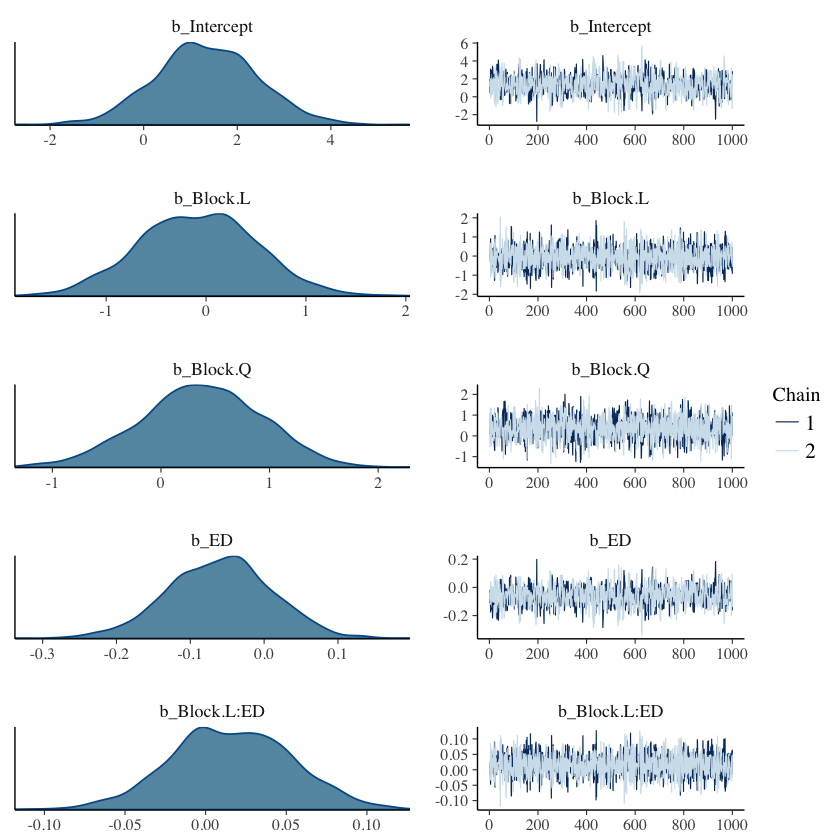

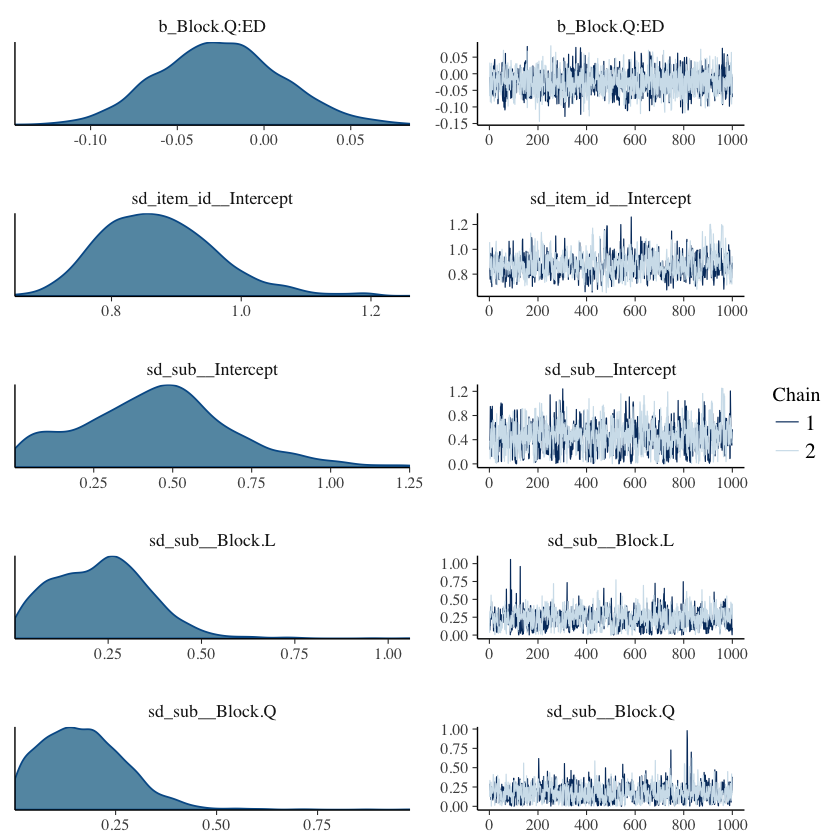

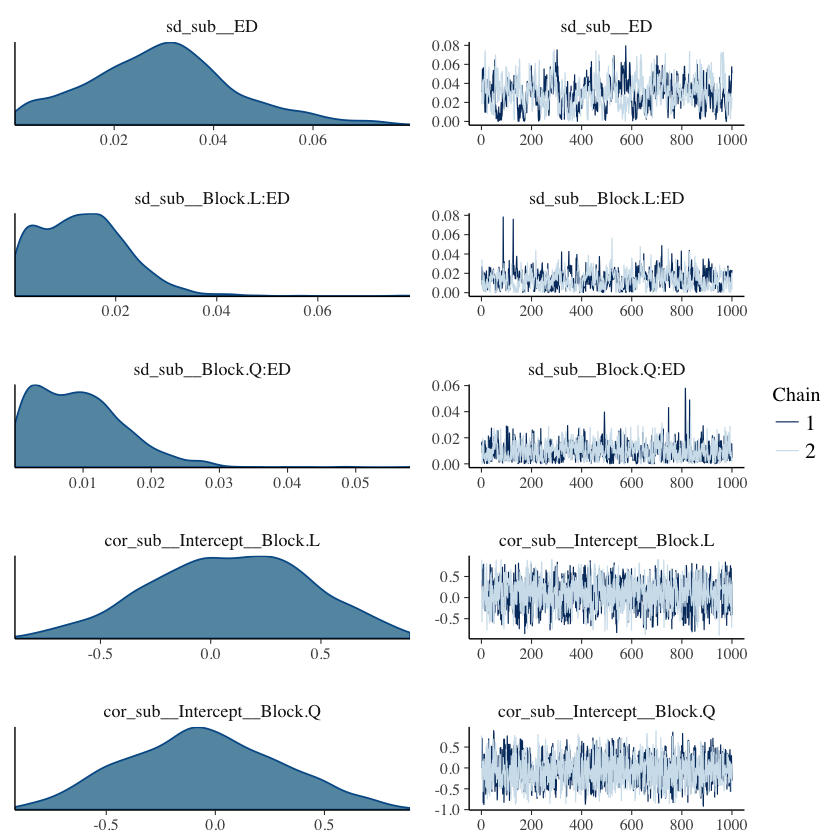

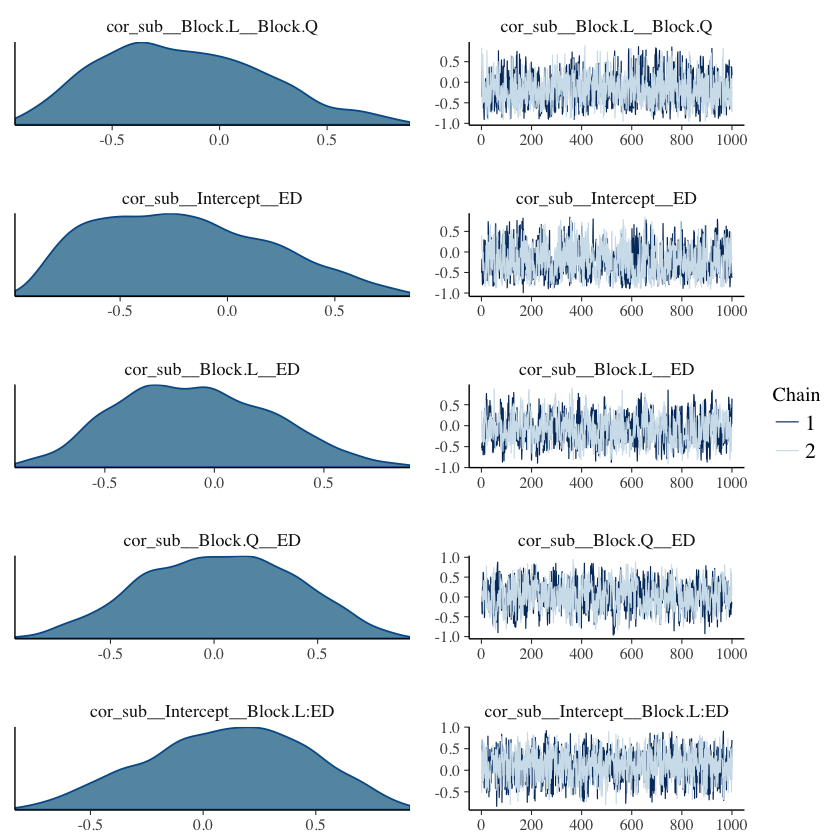

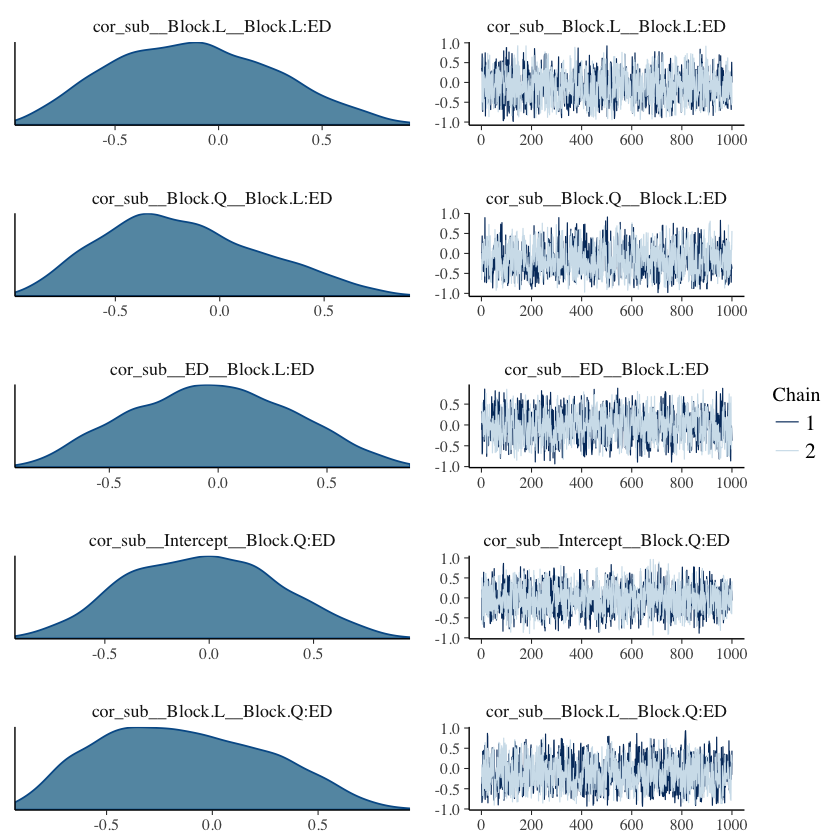

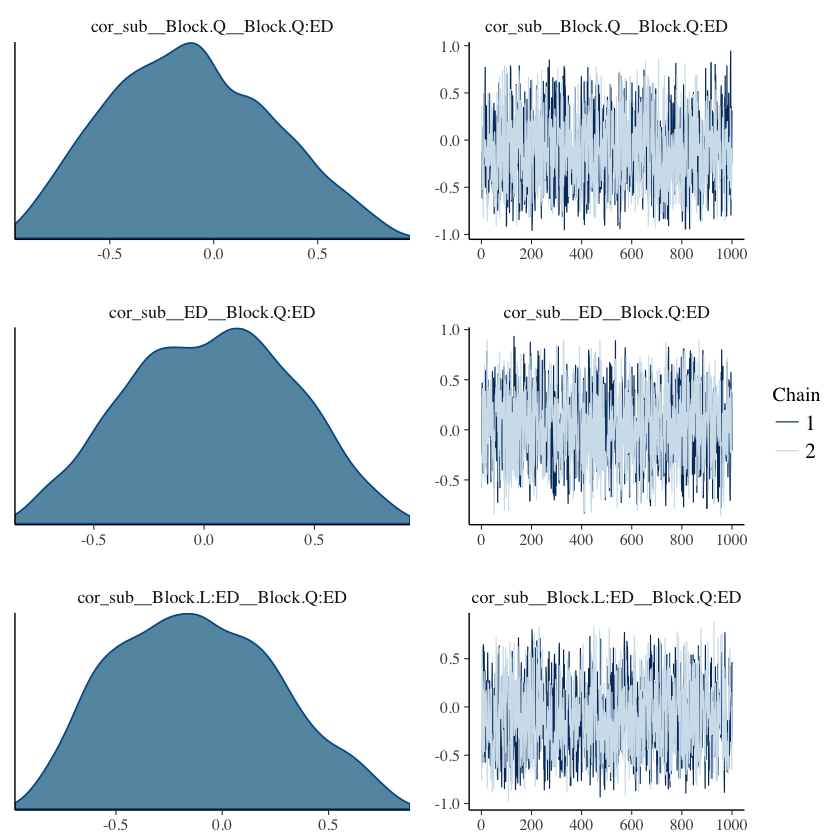

In [17]:
plot(discmodel1, ask = FALSE)

### Model predictions

Using 10 posterior samples for ppc type 'dens_overlay' by default.


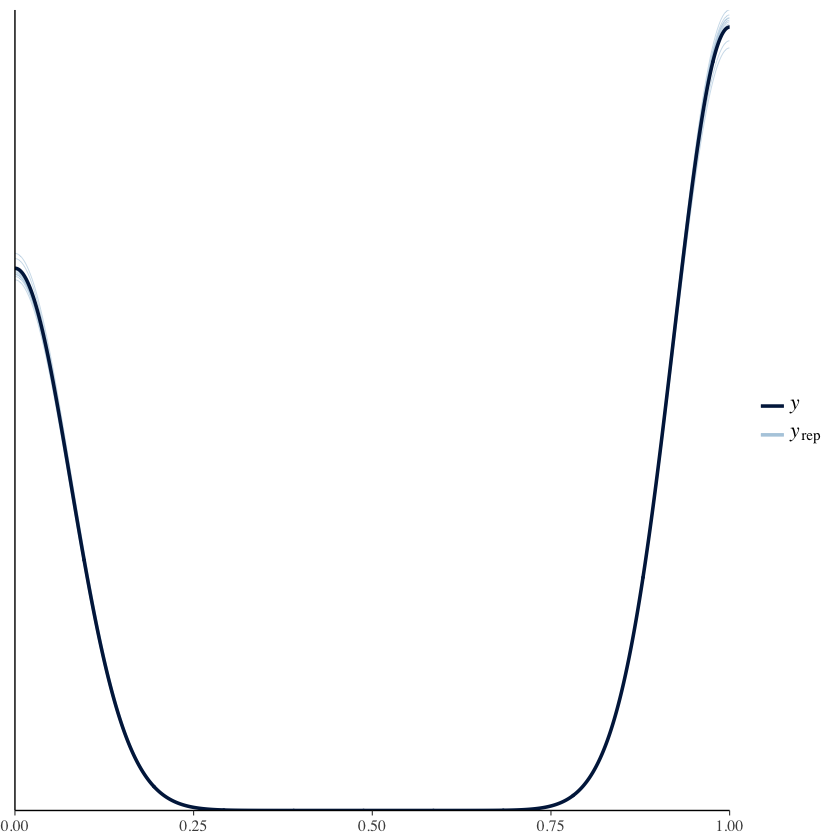

In [10]:
pp_check(discmodel1)

Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(Liste oder Vektor) des Typs 'NULL' angewendet”Warning message in is.na(x):
“is.na() auf nicht-(L

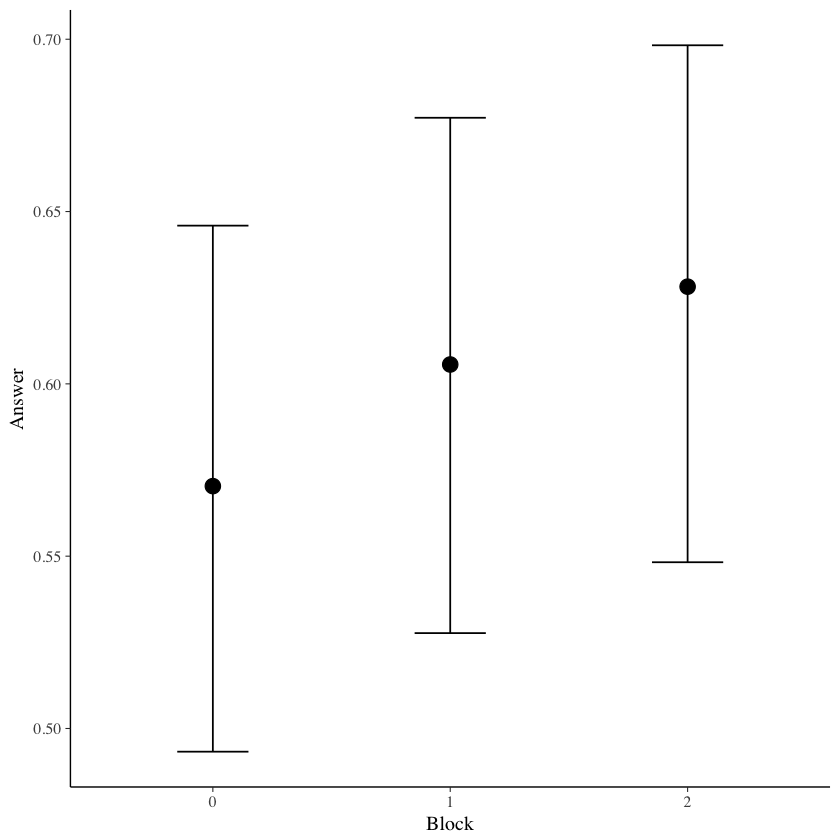

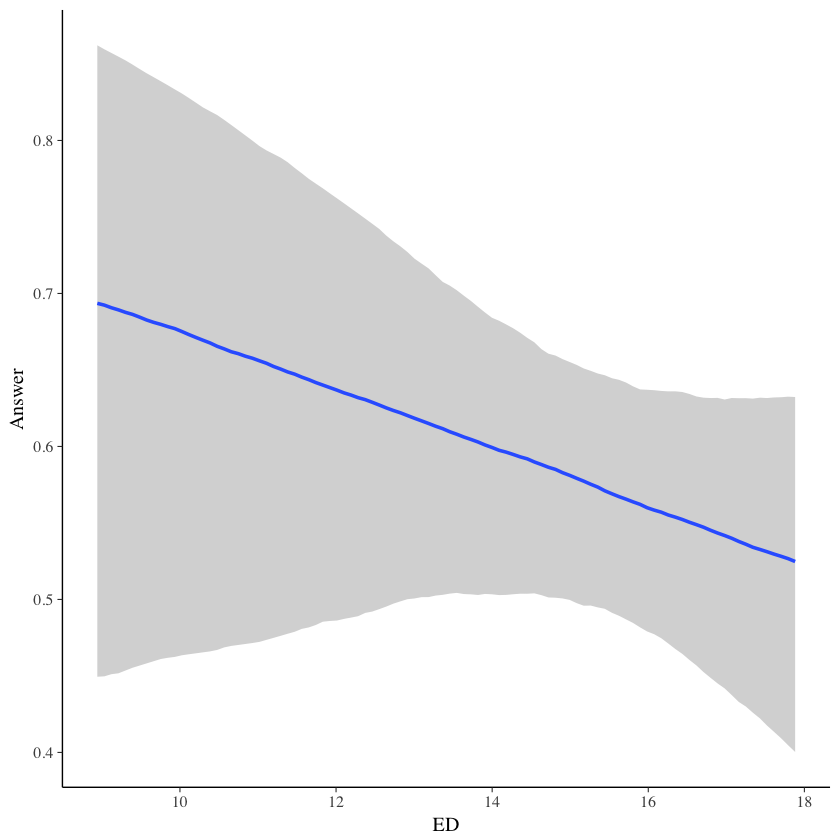

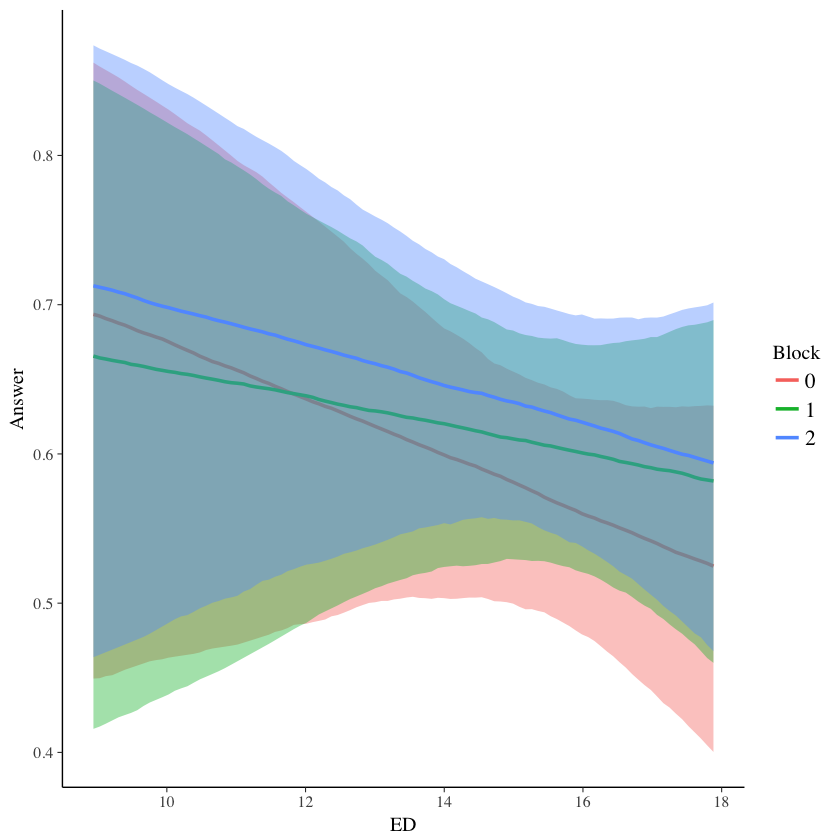

In [11]:
# Prediction by marginalized effects
plot(marginal_effects(discmodel1), ask = FALSE)

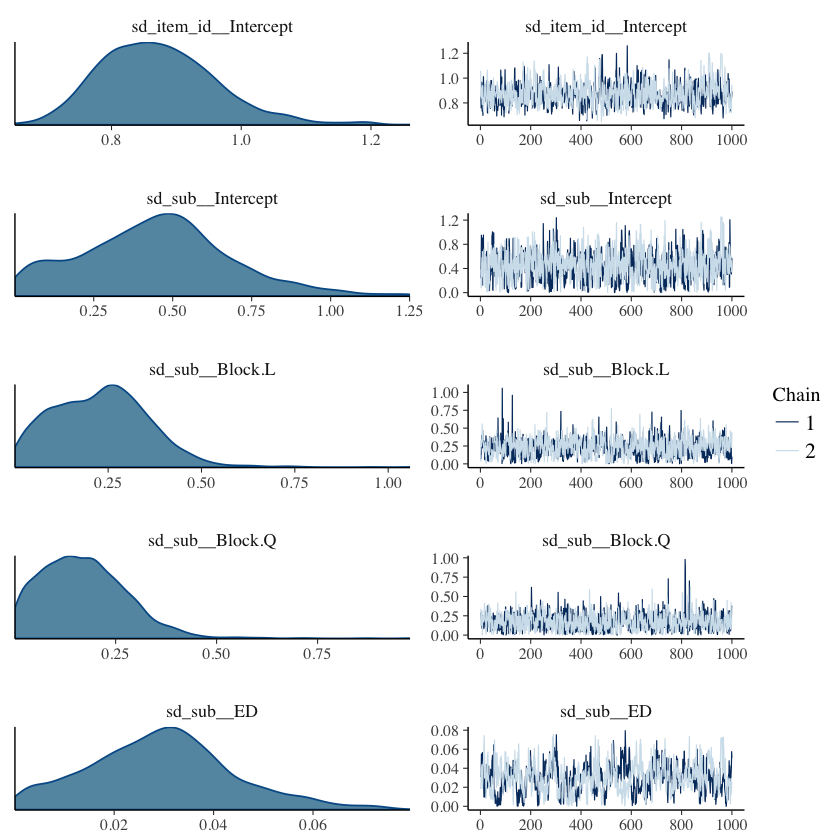

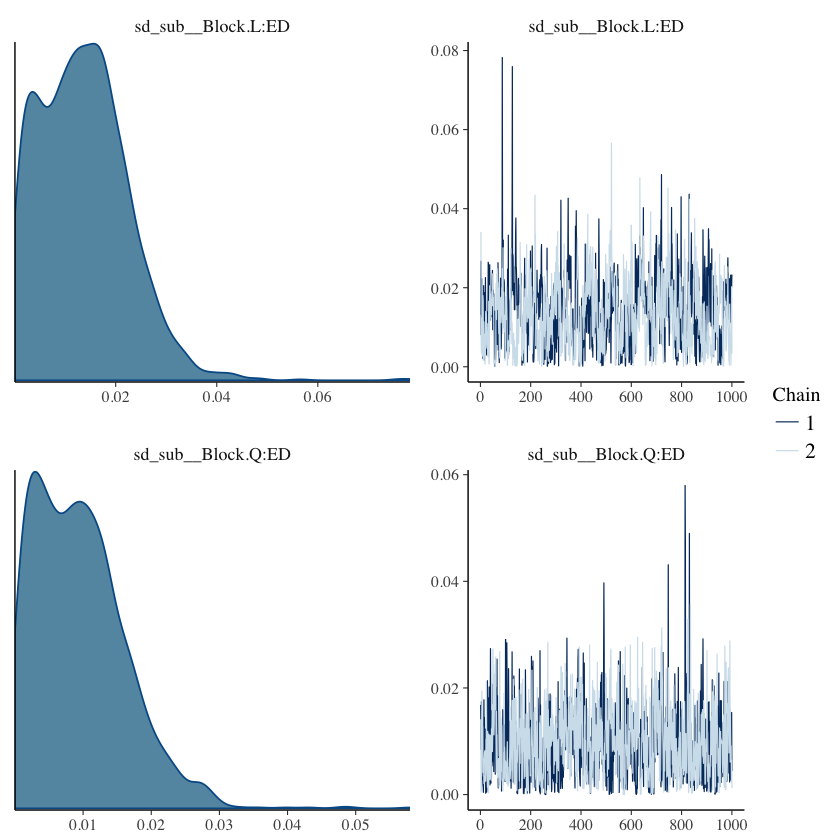

In [14]:
# Only plot posteriors of standard deviation for parameters
plot(discmodel1, pars="^sd")

**Conclusions:**
- the posterior standard deviation for the interaction parameters have most of the mass close to zero.
            sd_sub__Block.Q:ED
            sd_sub__Block.L:ED
- This could indicate that letting them freely varying is not necessary or may even indicate overfitting. We should set up model(s) with these factors as only fixed effects and compare via LOO.

# TODO

## Interpretability

Centralize continuous predictors (ED)
Effect coding for categorical predictors (Block)

## Hypothesis testing

Assess contrasts
Reduce model complexity and compare with LOO

## Outlier evaluation

Compare models based on data including and excluding outliers.